# Harvard Sociology Department Advising Network

## An Update

August 2017

In [1]:
# setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import string
import json
import re
import tweepy
import networkx as nx
from dateutil import parser
from collections import defaultdict
from os import listdir
from os.path import isfile, join
from itertools import combinations
from operator import itemgetter

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# read data
df = pd.read_excel('data/Advising_Data_JMM_Edits_August_2017.xls', sheetname=0)
df.head()

,StudentLast,StudentFirst,Committee1 (chair),Committee2,Committee3,Year,Committee4,Committee5,Unnamed: 8
0,Rubin,Julia,Skocpol,"Barnes, Louis","Bradach, Jeffrey",2001-2,"Ventresca, M",NaN,NaN
1,Gonzalez,Angela,Winship,Bobo,"Frank, David",2001-2,"Champagne, Duane",NaN,NaN
2,Gorman,Elizabeth,Marsden,Reskin,"Frank, David",2001-2,NaN,NaN,NaN
3,Frederick,Paula,Skocpol,Waters,"Frank, David",2001-2,NaN,NaN,NaN
4,Wasserman,Noam,Nohria,Baker,"Gompers, Paul",2001-2,Marsden,NaN,NaN


## 1. Create Faculty List

We will restrict the analysis of adivisng network to only current faculty. 

From email exchange with Jason:

* Include current (as well as emeritus) faculty and leave out recently-departed faculty -- excluding Filiz Garip, Tey Meadow, Matt Desmond, Nicholas Christakis, Chris Marquis, and Kathy Edin. But include Bruce Western, since, technically, he is on leave rather than resigned.

* 'Good' (whom we included in the first iteration of the network) is an affiliate. Best to omit her for this. 

* As for recently hired faculty, OK to omit faculty who have not served and are not serving on phd committees

* omit Lieberson, Vogel, Skocpol, and Khurana, and see if that helps with the readability

In [3]:
df.columns

Index([       u'StudentLast',       u'StudentFirst', u'Committee1 (chair)',
               u'Committee2',         u'Committee3',               u'Year',
               u'Committee4',         u'Committee5',         u'Unnamed: 8'],
      dtype='object')

In [4]:
# put all committee columns into a list 
# then remove duplicate names
fac_list = df['Committee1 (chair)'].values.tolist() + df.Committee2.values.tolist() + \
            df.Committee3.values.tolist() + df.Committee4.values.tolist() + df.Committee5.values.tolist()
fac_list = list(set(fac_list))
print len(fac_list)

186


In [5]:
print fac_list

[nan, u'Zuckerman', u'Wilson', u'Eck, Diana', u'Reskin', u'Skocpol', u'Beckert, Sven', u'Nohria, Nitin', u'Schneider, Ben', u'Desmond', u'Margolis, Joshua', u'Kanter, Rosabeth', u'Sampson*', u'Ellwood, David', u'Ferguson, Ann', u'Lucchino, Lawrence', u'Podolny, Joel', u'Western', u'Weller, Robert', u'Lorsch, Jay', u'Wildeman, Christopher', u'McGinn', u'DiTomaso, Nancy', u'Marsden', u'Whyte*', u'Lieberson', u'Marquis', u'Ammerman', u'de Sousa-Briggs, Xavier', u'Christakis', u'Edin, Kathryn', u'Hackman, J. Richard', u'Simon, Patrick', u'Polzer, Jeffrey', u'Ammerman, Nancy', u'Coffin, Brent', u'Vogel', u'Higgonet, Patrice', u"O'Mahony, Siobhan", u'McDonald, Rory', u'Sorensen, Aage', u'Nanda, Ashish', u'Szelenyi, Ivan', u'Wuthnow, Robert', u'Edmondson', u'Jencks', u'Rainwater, Lee', u'Marsden*', u'Wein, Frederic', u'Schor, Juliet B.', u'Gulati, Ranjay', u'Winship*', u'Van Maanen, John', u'Battilana, Julie', u'Lewis, Mary', u'Stuart, Toby E.', u'Bobo', u'Good', u'Carpenter, Daniel', u'Anteb

In [6]:
# by comparing faculty list on soc website and unique names in the dataset above

# omitted: 'Lieberson', 'Vogel', 'Khurana, Rakesh', 'Skocpol',

own_fac_list = ['Wilson', 'Sampson', 'Western', 'Marsden', 'Whyte', 
                'Jencks', 'Winship', 'Bobo', 'Brinton', 'Lei', 
                'Lamont', 'Dobbin', 'Bonikowski', 'Beckfield', 
                'Waters', 'Chang, Paul', 'Small', 'Killewald', 'Viterna', 
                'Patterson', 'Pager']
print len(own_fac_list)

21


## 2. Clean Data

In [7]:
# get student full names

def get_student(row):
    """
    Combine student last name and first name.
    """
    
    if pd.isnull(row['StudentLast']):
        return None
    return row['StudentLast'].strip()+','+row['StudentFirst'].strip()

df['Student'] = df.apply(get_student, axis=1)
df.head()

,StudentLast,StudentFirst,Committee1 (chair),Committee2,Committee3,Year,Committee4,Committee5,Unnamed: 8,Student
0,Rubin,Julia,Skocpol,"Barnes, Louis","Bradach, Jeffrey",2001-2,"Ventresca, M",NaN,NaN,"Rubin,Julia"
1,Gonzalez,Angela,Winship,Bobo,"Frank, David",2001-2,"Champagne, Duane",NaN,NaN,"Gonzalez,Angela"
2,Gorman,Elizabeth,Marsden,Reskin,"Frank, David",2001-2,NaN,NaN,NaN,"Gorman,Elizabeth"
3,Frederick,Paula,Skocpol,Waters,"Frank, David",2001-2,NaN,NaN,NaN,"Frederick,Paula"
4,Wasserman,Noam,Nohria,Baker,"Gompers, Paul",2001-2,Marsden,NaN,NaN,"Wasserman,Noam"


In [8]:
# look for duplicates in students - compare row number and unique student number
print df.shape[0], len(df.Student.unique())

227 226


In [9]:
# remove duplicate
print df.shape
df = df.drop_duplicates('Student')
print df.shape

(227, 10)
(226, 10)


## 2. Create Bipartite Network

In [10]:
def find_faculty(fac_name, net):
    """
    Given fac_name and bipartite network graph net, 
    return the node if fac_name is already a node in net.
    Otherwise, return None.
    
    If multiple nodes are found associated with fac_name, raise Exception.
    """
    
    fac = [n for n,d in net.nodes(data=True) if n==fac_name]
    
    if len(fac) == 0:
        return None
    elif len(fac) == 1:
        return fac[0]
    else:
        raise Exception, 'ERROR: multiple nodes for '+fac_name
    

In [11]:
# create an empty network
b = nx.Graph()
    

# iterate through each row
for i, row in df.iterrows():
    
    # skip the empty row
    if pd.isnull(row['StudentLast']):
        continue
            
    # add student node
    # attributes: 'last name,first name', year, bipartite=0
    b.add_node(row['Student'], year=row['Year'], bipartite=0)
        
    # add faculty nodes
    for col in ['Committee1 (chair)', 'Committee2', 'Committee3', 'Committee4', 'Committee5']:
        fac_name = row[col]
        
        if pd.isnull(fac_name): # not every student has 4 or 5 committee members
            break
        
        fac_name = fac_name.strip('*') # co-chairs are marked with asterisk, not used, remove     
            
        if fac_name in own_fac_list: # exclude faculty outside of soc dept
            # check if faculty is already added to the network
            fac = find_faculty(fac_name, b)
            
            if not fac: # not yet a node in the network
                b.add_node(fac_name, bipartite=1)
                
            # add student-faculty tie
            b.add_edge(row['Student'], fac_name)
            

## 3. Convert Bipartite to One-Mode Network

In [12]:
fac_nodes = [n for n,d in b.nodes(data=True) if d['bipartite']==1]
print len(fac_nodes) # SAME as the pre-specified faculty list, so every faculty has served/is serving on phd commmittee
print fac_nodes 

21
[u'Wilson', u'Western', u'Marsden', u'Pager', u'Viterna', u'Jencks', u'Bobo', u'Brinton', u'Lamont', u'Dobbin', u'Bonikowski', u'Beckfield', u'Waters', u'Chang, Paul', u'Winship', u'Sampson', u'Lei', u'Small', u'Whyte', u'Killewald', u'Patterson']


In [13]:
g = nx.bipartite.weighted_projected_graph(b, fac_nodes)
print g.edges(data=True)[:5] # print first five edges

[(u'Bobo', u'Wilson', {'weight': 6}), (u'Bobo', u'Patterson', {'weight': 1}), (u'Bobo', u'Waters', {'weight': 6}), (u'Bobo', u'Beckfield', {'weight': 2}), (u'Bobo', u'Lamont', {'weight': 4})]


## 4. Export networkx Object to Gephi Object

In [14]:
# rename two faculty names before exporting
g = nx.relabel_nodes(g, {'Chang, Paul':'Chang'})

In [15]:
nx.write_gexf(g, 'data/advising_network_2017_v2.gexf')

## 5. Analyze Network

### Collaboration Frequency

In [16]:
# find the tie with max weight
edge_data = g.edges(data=True)
weights = [e[2]['weight'] for e in edge_data]
weights.sort(reverse=True)
print weights

[16, 14, 12, 11, 11, 10, 9, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
[e for e in edge_data if e[2]['weight']==16]

[(u'Patterson', u'Winship', {'weight': 16})]

In [18]:
[e for e in edge_data if e[2]['weight']==14]

[(u'Wilson', u'Waters', {'weight': 14})]

In [19]:
[e for e in edge_data if e[2]['weight']==12]

[(u'Wilson', u'Sampson', {'weight': 12})]

In [20]:
[e for e in edge_data if e[2]['weight']==11]

[(u'Wilson', u'Lamont', {'weight': 11}),
 (u'Wilson', u'Winship', {'weight': 11})]

### Degree distribution

In [21]:
degrees = g.degree().items()
degrees.sort(key=itemgetter(1), reverse=True)
for d in degrees:
    print d

(u'Winship', 18)
(u'Beckfield', 17)
(u'Wilson', 16)
(u'Waters', 16)
(u'Lamont', 15)
(u'Killewald', 14)
(u'Patterson', 13)
(u'Brinton', 13)
(u'Viterna', 13)
(u'Bonikowski', 13)
(u'Western', 13)
(u'Sampson', 12)
(u'Whyte', 12)
(u'Jencks', 12)
(u'Marsden', 12)
(u'Dobbin', 11)
(u'Pager', 10)
(u'Bobo', 9)
(u'Small', 9)
(u'Lei', 3)
('Chang', 3)


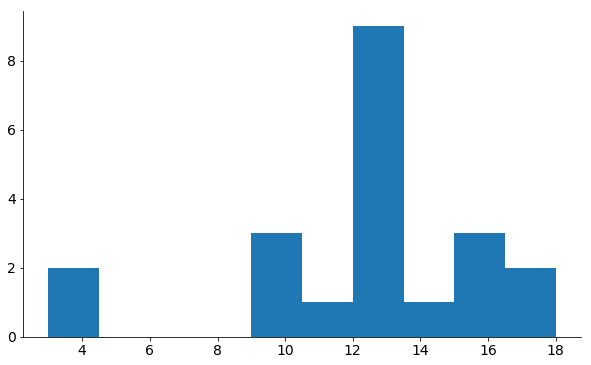

In [22]:
degrees = [v for k, v in g.degree().items()]
plt.hist(degrees)
remove_border()

### Collaboration frequency among the well-connected only

In [23]:
well_connected = [k for k, v in g.degree().items() if v>6] # degree > 6
print len(well_connected)
print well_connected

19
[u'Bobo', u'Wilson', u'Patterson', u'Sampson', u'Brinton', u'Viterna', u'Waters', u'Beckfield', u'Lamont', u'Small', u'Dobbin', u'Bonikowski', u'Western', u'Killewald', u'Winship', u'Pager', u'Whyte', u'Jencks', u'Marsden']


In [24]:
# print the edges with smallest weights - ONLY IF both faculties are well-connected 
[e for e in edge_data if e[2]['weight']==1 and e[0] in well_connected and e[1] in well_connected]

[(u'Bobo', u'Patterson', {'weight': 1}),
 (u'Bobo', u'Bonikowski', {'weight': 1}),
 (u'Bobo', u'Western', {'weight': 1}),
 (u'Wilson', u'Brinton', {'weight': 1}),
 (u'Wilson', u'Marsden', {'weight': 1}),
 (u'Sampson', u'Viterna', {'weight': 1}),
 (u'Sampson', u'Beckfield', {'weight': 1}),
 (u'Sampson', u'Pager', {'weight': 1}),
 (u'Patterson', u'Jencks', {'weight': 1}),
 (u'Patterson', u'Bonikowski', {'weight': 1}),
 (u'Patterson', u'Western', {'weight': 1}),
 (u'Jencks', u'Viterna', {'weight': 1}),
 (u'Jencks', u'Whyte', {'weight': 1}),
 (u'Jencks', u'Small', {'weight': 1}),
 (u'Brinton', u'Lamont', {'weight': 1}),
 (u'Brinton', u'Waters', {'weight': 1}),
 (u'Viterna', u'Killewald', {'weight': 1}),
 (u'Viterna', u'Whyte', {'weight': 1}),
 (u'Viterna', u'Marsden', {'weight': 1}),
 (u'Waters', u'Whyte', {'weight': 1}),
 (u'Waters', u'Beckfield', {'weight': 1}),
 (u'Waters', u'Western', {'weight': 1}),
 (u'Lamont', u'Western', {'weight': 1}),
 (u'Lamont', u'Pager', {'weight': 1}),
 (u'La

### Eigenvector centrality

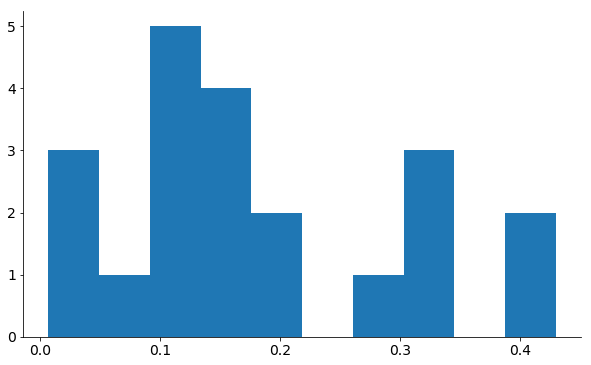

In [31]:
eigen = nx.eigenvector_centrality(g)
plt.hist(eigen.values())
remove_border()

In [35]:
x = sorted(eigen.items(), key=itemgetter(1), reverse=True)
names = map(itemgetter(0), x)
print 'top 5 on eigenvector centrality:', names[:5]

x = sorted(eigen.items(), key=itemgetter(1))
names = map(itemgetter(0), x)
print 'bottom 5 on eigenvector centrality:', names[:5]

top 5 on eigenvector centrality: [u'Wilson', u'Winship', u'Waters', u'Sampson', u'Patterson']
bottom 5 on eigenvector centrality: ['Chang', u'Lei', u'Pager', u'Small', u'Brinton']


### Betweenness centrality

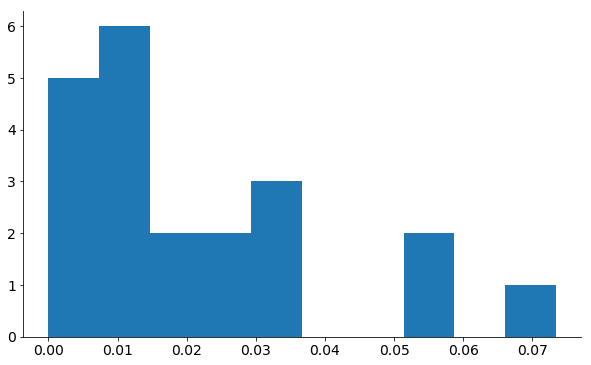

In [36]:
between = nx.betweenness_centrality(g)
plt.hist(between.values())
remove_border()

In [37]:
x = sorted(between.items(), key=itemgetter(1), reverse=True)
names = map(itemgetter(0), x)
print 'top 5 on betweenness centrality:', names[:5]

x = sorted(between.items(), key=itemgetter(1))
names = map(itemgetter(0), x)
print 'bottom 5 on betweenness centrality:', names[:5]

top 5 on betweenness centrality: [u'Winship', u'Brinton', u'Killewald', u'Viterna', u'Patterson']
bottom 5 on betweenness centrality: [u'Lei', 'Chang', u'Bobo', u'Small', u'Whyte']


### Missing ties

In [26]:
n = len(own_fac_list)
print '# of possible ties:', n*(n-1)/2
print '# of realized ties:', len(g.edges())

# of possible ties: 210
# of realized ties: 127


In [27]:
# which ties are missing?

edges = g.edges() # existing ties

for pair in combinations(own_fac_list, 2):
    
    if pair in edges:
        pass
    elif (pair[1], pair[0]) in edges: # change order and check in existing edges again
        pass
    elif pair[0] in well_connected and pair[1] in well_connected:
        print pair


('Wilson', 'Dobbin')
('Wilson', 'Pager')
('Sampson', 'Whyte')
('Sampson', 'Bobo')
('Sampson', 'Brinton')
('Sampson', 'Dobbin')
('Sampson', 'Bonikowski')
('Sampson', 'Small')
('Western', 'Whyte')
('Western', 'Brinton')
('Western', 'Bonikowski')
('Western', 'Small')
('Western', 'Viterna')
('Marsden', 'Bobo')
('Marsden', 'Bonikowski')
('Marsden', 'Small')
('Marsden', 'Killewald')
('Marsden', 'Patterson')
('Marsden', 'Pager')
('Whyte', 'Bobo')
('Whyte', 'Small')
('Whyte', 'Patterson')
('Whyte', 'Pager')
('Jencks', 'Bobo')
('Jencks', 'Brinton')
('Jencks', 'Lamont')
('Jencks', 'Dobbin')
('Jencks', 'Bonikowski')
('Jencks', 'Pager')
('Winship', 'Killewald')
('Bobo', 'Brinton')
('Bobo', 'Dobbin')
('Bobo', 'Small')
('Bobo', 'Killewald')
('Bobo', 'Viterna')
('Brinton', 'Bonikowski')
('Brinton', 'Small')
('Brinton', 'Pager')
('Lamont', 'Small')
('Lamont', 'Killewald')
('Dobbin', 'Waters')
('Dobbin', 'Viterna')
('Dobbin', 'Patterson')
('Beckfield', 'Viterna')
('Waters', 'Pager')
('Small', 'Viterna'